# Ultimate Technologies Inc. Take-Home Challenge

## Table of Contents:

* [Part 1 ‑ Exploratory data analysis](#Part_1)
* [Part 2 ‑ Experiment and metrics design](#Part_2)
* [Part 3 ‑ Predictive modeling](#Part_3)


In [1]:
#import packages

import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb

## Part 1 ‑ Exploratory data analysis<a id='Part_1'></a>

In this EDA section, we will do the following:
* Load the data:
    * logins.json - timestamps of user logins in a particular geographic location
* Aggregate the logins on 15-minute time intervals
* Visualize and describe the resulting time series of login counts to characterize the underlying patterns of the demand, reporting important features of the demand, such as daily cycles.

In [2]:
df = pd.read_json('logins.json')
df = df.sort_values(by='login_time').set_index('login_time')
df.head()

""
login_time
1970-01-01 20:12:16
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:36
1970-01-01 20:16:37


In [3]:
agg_15m = df.groupby(pd.Grouper(freq='15Min')).size() 

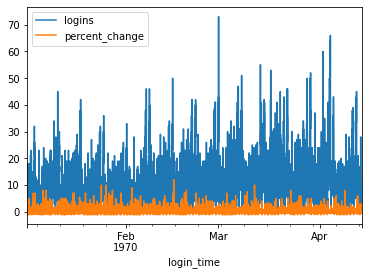

In [4]:
df = pd.DataFrame(agg_15m)
df = df.rename(columns={0:'logins'})
df['percent_change'] = df['logins'].pct_change()
df.plot();

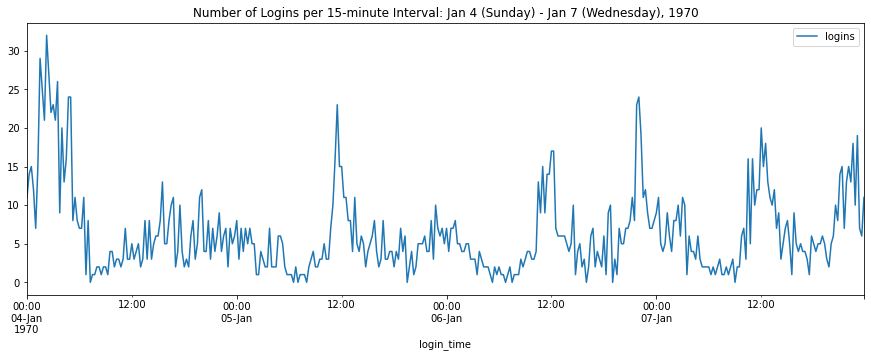

In [5]:
#Let's look at a 3-day span to see any trends throughout the day: 
df_subset = pd.DataFrame(agg_15m).loc['1970-01-04':'1970-01-07']
df_subset = df_subset.rename(columns={0:'logins'})
df_subset.plot(figsize=(15,5), title='Number of Logins per 15-minute Interval: Jan 4 (Sunday) - Jan 7 (Wednesday), 1970');

From the 3-day span of Jan 4 - Jan 7, we notice that Sunday (the weekend) has much higher ridership than the following two days (the weekdays). Ridership seems to spike during lunchtime, possibly because people may be eating out for lunch on a workday. On Tuesday and Wednesday, we see a spike close to 11pm. Ridership is particularly low around 5-7pm on weekdays.

Ridership appears to be highest on the weekends. On weekdays, there are spikes around 12pm and late at night.

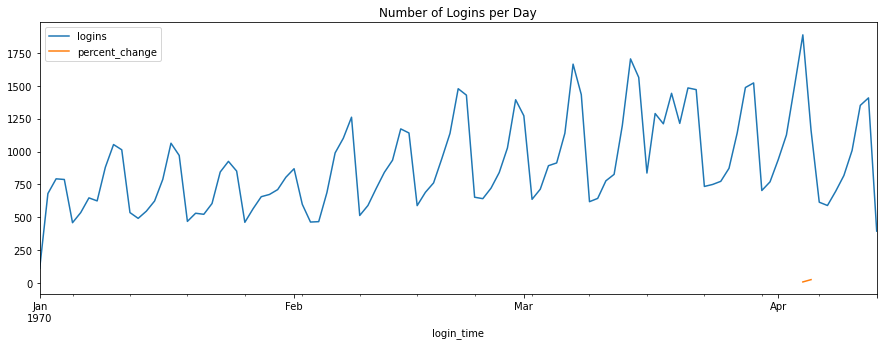

In [6]:
#resample daily, summing up each day's ridership
df_daily = df.resample('D').sum()
df_daily.plot(figsize=(15,5), title='Number of Logins per Day');

Looking at the daily sum plot, we see roughly 4 "bumps" every month. (These 4 bumps can very roughly be seen in the daily resample plot as well, but it is not nearly as clear). This could correspond to a weekly spike. For example, maybe ridership increases on weekends when people are going on outings; or conversely every weekend everyone stays in, so we see a dip in ridership. Looking online, we find that day where the peak occurs, like Jan 10/11, 1970, corresponds to Saturday/Sunday. There indeed is an increase of logins during weekends.

Looking at the daily sum plot, we also see an increasing trend from January to mid-March, and then a slight decline in ridership.

It would be worth looking into the weekly and monthly ridership demand as well. Resampling weekly would allow us to see trends beyond the weekly spikes in ridership.

In [8]:
#resample daily
df_daily_sum = df.resample('D').sum().drop(columns='percent_change') #sum the logins for each day
df_daily = df.resample('D').last() #sample the last daily login and pct_change

#resample weekly
df_weekly_sum = df.resample('W').sum().drop(columns='percent_change') #sum the logins for each week
df_weekly = df.resample('W').last()

#resample monthly
df_monthly_sum = df.resample('M').sum().drop(columns='percent_change') #sum the logins for each month
df_monthly = df.resample('M').last()


In [9]:
#Normalize df_weekly_sum and df_monthly_sum to make it comparable to df_daily_sum when plotting.
#Note: Our data only records up to April 13, so we give the monthly of April only 13 days,
#and we drop our final week (April 13-19) since it only has partial data.

df_weekly_sum['logins_norm'] = df_weekly_sum['logins']/7
df_weekly_sum = df_weekly_sum.drop(df_weekly_sum.tail(1).index) #drop the last row


monthly_normalized = [] #make an empty list
monthly_normalized.append(df_monthly_sum['logins'][0]/31) #31 days in Jan
monthly_normalized.append(df_monthly_sum['logins'][1]/28) #28 days in Feb
monthly_normalized.append(df_monthly_sum['logins'][2]/31) #31 days in Mar
monthly_normalized.append(df_monthly_sum['logins'][3]/13) #13 days recorded in April
df_monthly_sum['logins_norm'] = monthly_normalized


#Now the the weekly and monthly are normalized, re-calculate the growth/percent-change:
df_daily_sum['percent_change'] = df_daily_sum['logins'].pct_change() #re-calculate percent change
df_weekly_sum['percent_change'] = df_weekly_sum['logins_norm'].pct_change() #re-calculate percent change
df_monthly_sum['percent_change'] = df_monthly_sum['logins_norm'].pct_change() #re-calculate percent change


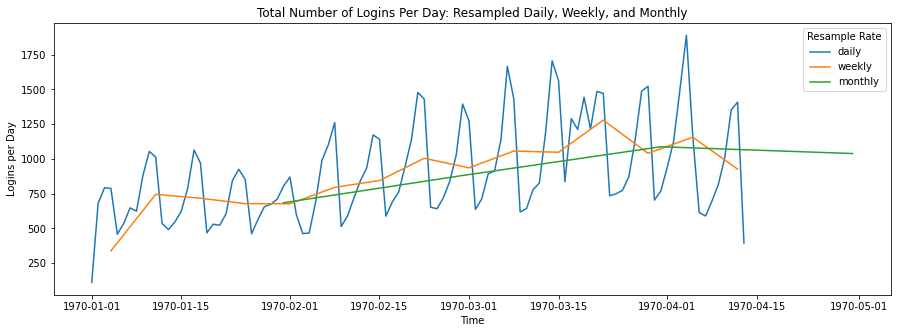

In [10]:
#Plot the daily, weekly, and monthly ridership, were we summed over each interval. Use the normalized values.

_=plt.figure(figsize=(15,5))
_=plt.plot(df_daily_sum.index, df_daily_sum.logins, '-',
           df_weekly_sum.index, df_weekly_sum.logins_norm, '-',  #use normalized weekly value
           df_monthly_sum.index, df_monthly_sum.logins_norm, '-') #use normalized monthly value
_=plt.legend(['daily', 'weekly', 'monthly'], title='Resample Rate', loc='best')
_=plt.ylabel('Logins per Day')
_=plt.xlabel('Time')
_=plt.title('Total Number of Logins Per Day: Resampled Daily, Weekly, and Monthly')


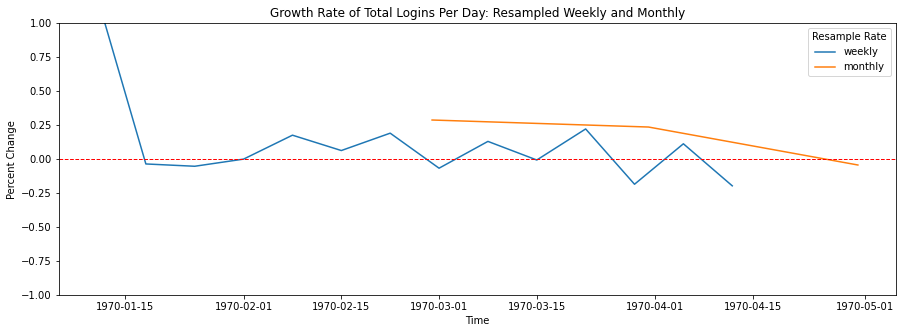

In [11]:
#What is the weekly and monthly growth rates?
#Plot the percent change of the sum of logins each day, resampled for weekly and monthly

_=plt.figure(figsize=(15,5))
_=plt.plot(df_weekly_sum.index, df_weekly_sum.percent_change,'-',
           df_monthly_sum.index, df_monthly_sum.percent_change,'-')
_=plt.axhline(y=0, linewidth=1, color='r', linestyle='--')
_=plt.legend(['weekly', 'monthly'], title='Resample Rate', loc='best')
_=plt.ylabel('Percent Change')
_=plt.xlabel('Time')
_=plt.ylim([-1,1])
_=plt.title('Growth Rate of Total Logins Per Day: Resampled Weekly and Monthly')


Weekly Ridership is expected to increase by 219.88 logins per week.


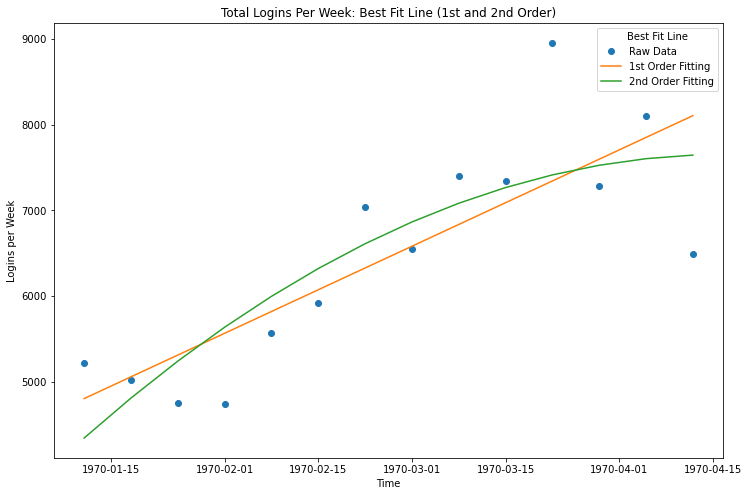

In [13]:
#Plot the best-fit lines for weekly ridership. This will give us an idea of the general trend of the ridership.

y_values = df_weekly_sum['logins'][1:] #exclude the 1st value as it's an incomplete week
#Note: we're not using the normalized ridership (i.e. not normalized to daily)

x_values = np.linspace(0,1,(len(df_weekly_sum)-1))

poly_degree = 1
coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
first_order = poly_eqn(x_values)
print('Weekly Ridership is expected to increase by', round(coeffs[0]/len(df_weekly_sum),2),'logins per week.')

poly_degree = 2
coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
second_order = poly_eqn(x_values)
# print('Weekly Ridership is expected to increase by', round((coeffs[1]+coeffs[0])/15,2),'each week.') #gives same as above

_=plt.figure(figsize=(12,8))
_=plt.plot(df_weekly_sum.index[1:], df_weekly_sum.logins[1:],'o', 
           df_weekly_sum.index[1:],first_order,'-',
           df_weekly_sum.index[1:],second_order,'-')
_=plt.legend(['Raw Data', '1st Order Fitting', '2nd Order Fitting'], title='Best Fit Line', loc='best')
_=plt.ylabel('Logins per Week')
_=plt.xlabel('Time')
_=plt.title('Total Logins Per Week: Best Fit Line (1st and 2nd Order)')


Monthly Ridership is expected to increase by 2853.61 logins per month.


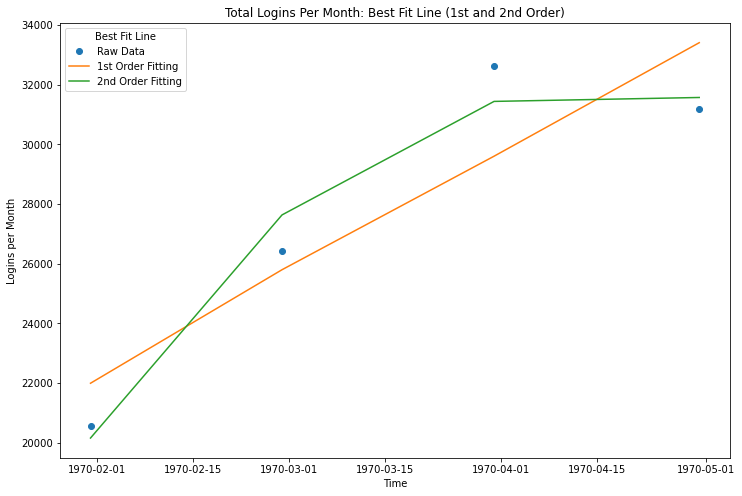

In [14]:
#simiarly, check the monthly trend.

y_values = df_monthly_sum['logins_norm']*30 
#Note: we use logins_norm because of the partial data for month of April.
#We multiply by 30 to scale it back to a monthly ridership total.

x_values = np.linspace(0,1,len(df_monthly_sum))

poly_degree = 1
coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
first_order = poly_eqn(x_values)
print('Monthly Ridership is expected to increase by', round(coeffs[0]/len(df_monthly_sum),2),
      'logins per month.') 

poly_degree = 2
coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
second_order = poly_eqn(x_values)

_=plt.figure(figsize=(12,8))
_=plt.plot(df_monthly_sum.index, df_monthly_sum.logins_norm*30,'o', 
           df_monthly_sum.index,first_order,'-',
           df_monthly_sum.index,second_order,'-')
_=plt.legend(['Raw Data', '1st Order Fitting', '2nd Order Fitting'], title='Best Fit Line', loc='best')
_=plt.ylabel('Logins per Month')
_=plt.xlabel('Time')
_=plt.title('Total Logins Per Month: Best Fit Line (1st and 2nd Order)')


From the above plots, we learn the following:
* __Total Number of Logins Per Day: Resampled Daily, Weekly, and Monthly__
    * This is by far our most informative plot.
    * Ridership increases on weekends and drops on weekdays.
    * The weekly and monthly lines show an increasing trend from January to mid-March, and then a slight decline in ridership into April.
    
* __Growth Rate of Total Logins Per Day: Resampled Weekly and Monthly__
    * Growth Rate has been mostly positive, but lately is trending negative. This reflects the slight decline we see in mid-March to mid-April.
    
* __Number of Logins per 15-minute Interval: Jan 4 (Sunday) - Jan 7 (Wednesday), 1970'__
    * Ridership spikes during lunchtime (12pm), possibly because people may be eating out for lunch on a workday. 
    * On some weekdays, we see a spike late at night (close to 11pm). 
    * Ridership is particularly low around 5-7pm on weekdays.

* __Total Logins Per Week: Best Fit Line (1st and 2nd Order)__ & __Total Logins Per Month: Best Fit Line (1st and 2nd Order)__
    * Weekly Ridership is expected to increase by 219.88 logins per week.
    * Monthly Ridership is expected to increase by 2853.61 logins per month (i.e. approx. 713 logins per week).
    * This disparity between our estimated weekly ridership and monthly ridership is likely due mainly to the differences in granularity. The Monthly Ridership best fit line is based off of 4 datapoints, 1 of which is an incomplete month (the dataset ends at April 13). I would recommend going with the more conservative estimate of a general 220 additional logins per week.

In summary, ridership will likely increase each week by approximately 220 logins per week, with a higher spike in ridership on weekends and a drop on weekdays. On a daily basis, ridership increases during noontime lunch and late in the evening for weekdays, and stays fairly busy throughout the day on the weekend.

## Part 2 ‑ Experiment and metrics design<a id='Part_2'></a>

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms. A two-way toll bridge causes drivers to tend to be exclusive to each city. The managers of city ops for the two cities propose an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    * How you will implement the experiment.
    * What statistical test(s) you will conduct to verify the significance of the observation.
    * How you would interpret the results and provide recommendations to the city operations team, along with any caveats.

__GTang response:__

1. __What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?__

The purpose behind this experiment is to make more drivers available in both the cities of Gotham and Metropolis. I initially wanted to choose "revenue" as the key metric, but because the problem statement does not explain the underlying reason for the experiment (whether it's to increase revenue, market share, or customer satisfaction), "revenue" is not the most appropriate metric. 

If the cities have more drivers available, it stands to reason that each driver who uses the toll bridge will end up taking on more rides, especially since the cities have complementary circadian rhythms (i.e. a driver could serve Metropolis during the day and Gotham during the night). Therefore, the key metric is __"number of rides"__, and the key measure of success is __a statistically significant increase in the mean number of rides given per driver in the experimental group.__ 

2. __Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:__
    * __How you will implement the experiment.__
    * __What statistical test(s) you will conduct to verify the significance of the observation.__
    * __How you would interpret the results and provide recommendations to the city operations team, along with any caveats.__

__2. Experiment:__ 

I would conduct an A/B Test. The drivers in Gotham and Metropolis will be split into 2 groups: a control group (no toll reimbursement) and a test group (reimbursing all toll costs).

__2A. How you will implement the experiment:__ 

We want to make sure the experiment is successful before we fully roll out the new toll reimbursement policy. Using an A/B Test Sample Size Calculator, if we want to properly evaluate an A/B test with 20% Baseline Conversion Rate, 20% Minimum Detectable Effect, and 95% Statistical significance, then we want a sample size of 1,100 for each group. What this means is, we expect at least 20% of drivers with the toll reimbursement policy to utilize it well (i.e. fulfill more ride requests), and we will be able to detect 80% of the time whether the variation's underlying conversion rate is actually 16% or 24% (20%, +/- 20% × 20%). 

I do not have the total number of drivers in both cities, but if it exceeds 2,200, then we can assign 550 Gotham drivers and 550 Metropolis drivers into the test group, and 550 Gotham drivers and 550 Metropolis drivers into the control group. We follow these drivers over the course of 1 month (or, at the very least, at least 1 full week to account for weekly variations in ridership demand), and then evaluate whether at least 20% of the drivers in the test group has significantly increased the number of rides they give.

If instead we do not have at least 2,200 drivers available between the 2 cities, we should take all of our drivers available and split them evenly into the test and control groups. (If the number of drivers between cities differs much, we can do this pseudo-randomly, by splitting the Gotham drivers 50/50 and then the Metropolis drivers 50/50 between the groups.) Using the number of available drivers, we work backwards in the A/B Test Sample Size Calculator, in order to find the appropriate Baseline Conversion Rate and MDE we use for our sample size.

(A/B Test Sample Size Calculator: https://www.optimizely.com/sample-size-calculator/?conversion=20&effect=20&significance=95)

__2B. What statistical test(s) you will conduct to verify the significance of the observation:__

I will conduct a __t-test__ to evaluate the difference between the averages of the test and control groups. We use t-tests when the sample size is small or the population standard deviation is unknown, which is definitely our case here.

I will also calculate the __confidence intervals__ for the number of rides given by our test and control groups. While the confidence interval is not a hypothesis test, it can give us a range to see where the true mean actually lies.

__2C. How you would interpret the results and provide recommendations to the city operations team, along with any caveats:__

For the t-test, if the difference in mean number of rides given per driver in the test group compared to the control group is not statistically significant, then we accept our null hypothesis that reimbursing tolls _does not_ increase the drivers serving both cities, and we cancel the policy. If we achieve statistical significance, then we should implement the policy with a full roll-out. As described above, our sample size was selected based on a 95% Statistical Significance, meaning there is a 1 in 20 chance that our experiment appears to be successful but the null hypothesis is actually true (i.e. we obtain a False Positive or Type 1 Error).

For the confidence interval, like the t-test, it will be calculated with 95% Statistical Significance, meaning that 95% of the time we expect the true mean to fall withint our range of values, but there is still a 1 in 20 chance that the true mean falls outside of that range.

Hypothesis testing is extremely useful and applicable in many business circumstances, but with limitations. Any test is only a subset of the total population, and so we will never truly know the true mean and true variance and behaviors of our population. There are also limitations with the power of our test--if we do not have a large enough sample size, our ability to detect and accurately evaluate the conversion rate decreases.

__end response.__

## Part 3 ‑ Predictive modeling<a id='Part_3'></a>


Ultimate is interested in predicting rider retention. Use this dataset of a cohort of users who signed up for an account in Jan 2014; their data was pulled several months later. The user is considered retained if they were "active" (i.e. took a trip) in the preceding 30 days.

Use this dataset to help understand what factors are the best predictors for retention. Offer suggestions to operationalize those insights to help Ultimate. 

1. Perform any cleaning, EDA, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

### 1. Perform any cleaning, EDA, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?


In [15]:
#Load the data
df = pd.read_json('ultimate_data_challenge.json')

In [16]:
df.info()
#Here we see that avg_rating_of_driver has 8k+ null values, phone has ~400, and avg_rating_by_driver has ~200 null.
#We will need to impute the data, with either the mean or median (for rating) and with the mode (for phone type).

#There are also categorial variables that need to be one-hot-encoded (city, phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [17]:
df.describe(include='all').T
#Our categorical variables (city, phone) have only 3 and 2 values, respectively.
#They're suitable for one-hot-encoding (they do not have high cardinality)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
city,50000,3,Winterfell,23336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trips_in_first_30_days,50000,NaN,NaN,NaN,2.2782,3.79268,0,0,1,3,125
signup_date,50000,31,2014-01-18,2948,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,41878,NaN,NaN,NaN,4.60156,0.617338,1,4.3,4.9,5,5
avg_surge,50000,NaN,NaN,NaN,1.07476,0.222336,1,1,1,1.05,8
last_trip_date,50000,182,2014-06-29,2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone,49604,2,iPhone,34582,NaN,NaN,NaN,NaN,NaN,NaN,NaN
surge_pct,50000,NaN,NaN,NaN,8.84954,19.9588,0,0,0,8.6,100
ultimate_black_user,50000,2,False,31146,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,50000,NaN,NaN,NaN,60.9261,37.0815,0,33.3,66.7,100,100


In [18]:
#convert date-time columns to datetime
df.signup_date = pd.to_datetime(df.signup_date)
df.last_trip_date = pd.to_datetime(df.last_trip_date)

#impute missing data
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.median()) #impute with median
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.median()) #impute with median
df.phone = df.phone.fillna(df.phone.mode()) #impute with the mode (most common phone type)

#One-hot encode categorial variables

one_hot = pd.get_dummies(df['city'])
df = df.drop('city',axis = 1)
df = df.join(one_hot)

one_hot = pd.get_dummies(df['phone'])
df = df.drop('phone',axis = 1)
df = df.join(one_hot)

#convert to binary
df.ultimate_black_user = df.ultimate_black_user*1

#Add a column for user retention. The user is considered retained if they took a trip in the preceding 30 days.
#We can see if the last_trip_date of the user falls between the max() date and 30 days prior to max() date, inclusive.

end_of_range = df.last_trip_date.max()
beg_of_range = end_of_range - pd.Timedelta("30 days")

df['retained'] = (df['last_trip_date'] >= beg_of_range)*1 #convert to binary

print(round((df['last_trip_date'] >= beg_of_range).sum()/len(df)*100,2),'% of the observed users were retained.')

37.61 % of the observed users were retained.


Our dataset is now cleaned and ready for modeling. There are no more null values, all categoricals have been one-hot encoded, and we have determined that __37.61 % of the observed users were retained.__

Before we continue with modeling, let's look a bit at the relationships between variables. We will use a heatmap and PCA.

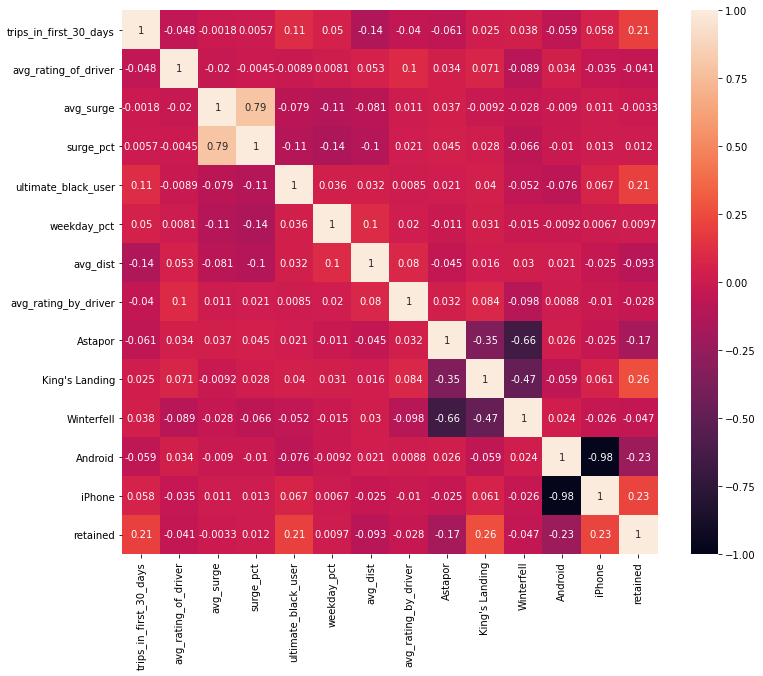

In [19]:
plt.subplots(figsize=(12,10)) 
sns.heatmap(df.corr(), vmin = -1, vmax = 1, annot=True,);

Looking at the heatmap, we see some relationships between retention and the other features:
* Retention has a slight positive correlation (+0.23) with iPhones and slight negative correlation (-0.23) with Androids.
* Retention has a slight positive correlation (+0.26) for those traveling to King's Landing.
* Retention has a slight positive correlation (+0.21) with how many trips the user made within the first 30 days of making an account.
* Retention has a slight positive correlation (+0.21) for users who are ultimate_black users.

In [20]:
y = df['retained']
X = df.drop(columns = ['retained', 'signup_date', 'last_trip_date']) #drop the target variable and datetime variables

#Here we use MinMaxScaler because this way we can preserve the 0/1 binary values for the majority of our features.
#(On the other hand, if we used StandardScaler, we lose the binary quality of our other features.)
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

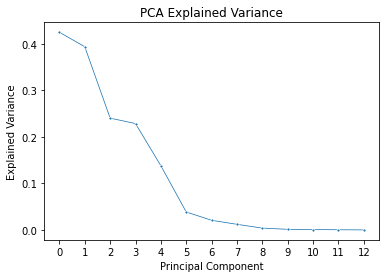

In [21]:
#PCA visualization. How many features explain the variance of our data?

pca = PCA()
pca.fit(X_scaled) #We look at X_scaled here, because X will just show all variation in days_of_use

y_pca = pca.explained_variance_
x_pca = np.arange(len(y_pca))
_=sns.lineplot(x_pca,y_pca, marker='.', size=20, legend=False)
_=plt.ylabel('Explained Variance')
_=plt.xlabel('Principal Component')
_=plt.title('PCA Explained Variance')
_=plt.xticks(np.arange(len(y_pca)))

#the elbow point (subjective) seems to occur twice: once at 2 and once more at 5.

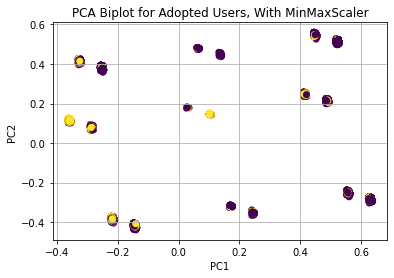

In [22]:
#Below is code to plot a PCA biplot, adapted from the author Serafeim Loukas of the following article:
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

pca = PCA()
x_new = pca.fit_transform(X_scaled)

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = y.to_numpy())
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.title('PCA Biplot for Adopted Users, With MinMaxScaler')
plt.show()

From the PCA Explained Variance, we can see that the first 5 principal components explain most of the variance. This gives us an idea that at the end of our modeling step, we want to focus on just the 5 or so most important features, when making suggestions to operations.

From the PCA biplot, we do not get much information. Since most of our features are binary/boolean, we expect such a plot. Since there isn't a continuous distribution, we should consider using Decision Trees as our classification model.

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.


In [23]:
#70/30 Train/Test split, then train our scaler only on the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35000, 13), (15000, 13), (35000,), (15000,))

[23:28:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy=0.785
F1-score=0.782
Precision=0.744
Recall=0.662

Confusion Matrix without Normalization
[[7988 1303]
 [1928 3781]]

Confusion Matrix with Normalization
[[0.86 0.14]
 [0.34 0.66]]


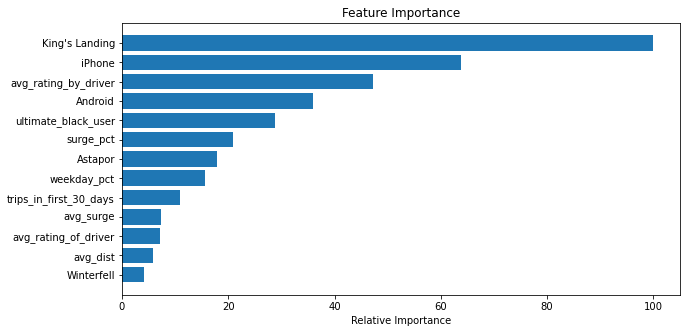

In [25]:
#As stated from the description of the PCA biplot, since many of our features are boolean and not continuous, 
# we can look into using a Decision Tree Classifier. 
# Since the current gold standard for Decision Trees is XGBoost, we'll use that.

#Model with XGBoost, and plot the feature importance.

#Modeling step:
clf = xgb.XGBClassifier(seed=1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print()
print('Accuracy=%.3f' % (ac))
print('F1-score=%.3f' % (f1))
print('Precision=%.3f' % (pr))
print('Recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))


#Feature Importance:
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(-feature_importance)

# print('The top',sorted_idx.size,'most important features for XGB Classifier.')

pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()

plt.show()

In [26]:
#We used XGBoost out-of-the-box. Let's do some simple hyperparameter tuning, using 5-fold cross-validation.

#parameter grid to search for best param combination
n_estimators = [int(n) for n in np.logspace(start=1, stop=2.5, num=10)]
max_depth = [int(x) for x in np.linspace(start=3, stop=30, num = 10)]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5]

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth,  
                  learning_rate = learning_rate)

#create the model
clf_xgb = xgb.XGBClassifier(seed=1)

#search 100 different combinations (n_iter=100) and use all processors (n_jobs=-1)
xgb_cv= RandomizedSearchCV(estimator = clf_xgb, 
                          param_distributions = param_grid,
                          cv = 5,
                          n_iter = 60, 
                          n_jobs = -1,
                         )

xgb_cv.fit(X_train, y_train)

print("Best Score:", str(xgb_cv.best_score_))
print("Best Parameters:", str(xgb_cv.best_params_))

[23:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.7864571428571429
Best Parameters: {'n_estimators': 14, 'max_depth': 6, 'learning_rate': 0.3}


C:\Users\grace\anaconda3\envs\TestEnv9\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [27]:
#Use the "Best Parameters" we found to model the test data again.

clf = xgb.XGBClassifier(n_estimators= 215, max_depth= 6, learning_rate= 0.1, seed=1) #use our "Best Parameters" we found
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print()
print('Accuracy=%.3f' % (ac))
print('F1-score=%.3f' % (f1))
print('Precision=%.3f' % (pr))
print('Recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

[23:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Accuracy=0.788
F1-score=0.785
Precision=0.747
Recall=0.669

Confusion Matrix without Normalization
[[7998 1293]
 [1892 3817]]

Confusion Matrix with Normalization
[[0.86 0.14]
 [0.33 0.67]]


N_neighbors: 1 , Train Score: 0.9967 , Test Score: 0.7091
N_neighbors: 2 , Train Score: 0.8549 , Test Score: 0.7193
N_neighbors: 3 , Train Score: 0.8531 , Test Score: 0.7329
N_neighbors: 4 , Train Score: 0.8222 , Test Score: 0.7383
N_neighbors: 5 , Train Score: 0.8217 , Test Score: 0.7424
N_neighbors: 6 , Train Score: 0.8076 , Test Score: 0.7481
N_neighbors: 7 , Train Score: 0.8077 , Test Score: 0.7505
N_neighbors: 8 , Train Score: 0.8004 , Test Score: 0.7533
N_neighbors: 9 , Train Score: 0.8 , Test Score: 0.7541
N_neighbors: 10 , Train Score: 0.7951 , Test Score: 0.7579
N_neighbors: 11 , Train Score: 0.7943 , Test Score: 0.7588
N_neighbors: 12 , Train Score: 0.7923 , Test Score: 0.7625
N_neighbors: 13 , Train Score: 0.7911 , Test Score: 0.7637
N_neighbors: 14 , Train Score: 0.7895 , Test Score: 0.7627
N_neighbors: 15 , Train Score: 0.7881 , Test Score: 0.7619
N_neighbors: 16 , Train Score: 0.787 , Test Score: 0.7629
N_neighbors: 17 , Train Score: 0.7867 , Test Score: 0.7638
N_neighbor

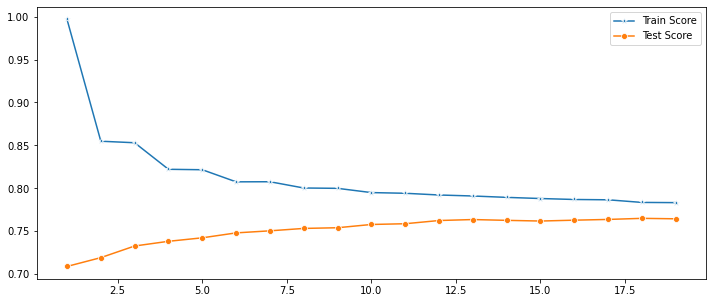

In [28]:
#Instead of XGBoost, let's try K Nearest Neighbors.

#Find the best value for n_neighbors

test_scores = []
train_scores = []

for i in range(1,20):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))
        
for i in range(len(test_scores)):
    print('N_neighbors:',i+1,', Train Score:', round(train_scores[i],4), ', Test Score:', round(test_scores[i], 4))
    
print('n_neighbors =',test_scores.index(max(test_scores))+1, 'is the best parameter.')
    
plt.figure(figsize=(12,5))
_ = sns.lineplot(range(1,20),train_scores,marker='*',label='Train Score')
_ = sns.lineplot(range(1,20),test_scores,marker='o',label='Test Score')

In [29]:
knn = KNeighborsClassifier(18) #Use "best parameter" n_neighbors = 18
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print()
print('Accuracy=%.3f' % (ac))
print('F1-score=%.3f' % (f1))
print('Precision=%.3f' % (pr))
print('Recall=%.3f' % (re))
print()
print('Confusion Matrix without Normalization')
print(cm)
print()
print('Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))


Accuracy=0.788
F1-score=0.760
Precision=0.727
Recall=0.613

Confusion Matrix without Normalization
[[7979 1312]
 [2212 3497]]

Confusion Matrix with Normalization
[[0.86 0.14]
 [0.39 0.61]]


Here we used XGBoost Classifier and K Nearest Neighbors to classify whether someone will be retained as an active user in their 6th month on the system. The reason why I used XGBoost is because, as stated from the description of the PCA biplot, many of our features are boolean and not continuous, so I chose to use a Decision Tree Classifier instead of Logistic Regression. I used KNN as a comparison against XGB.

Other possible models include Naive Bayes and SVC, but generally XGBoost is known to work fairly well.

Model performance was evaluated based on accuracy, F1-score, Precision, and Recall. The Confusion Matrix for each model is also included. 

* XGBoost Classifier:
    * __Accuracy=0.788__
    * __F1-score=0.785__
    * __Precision=0.747__
    * __Recall=0.669__
    * Confusion Matrix with Normalization
        * [0.86 0.14]
        * [0.33 0.67]

* K Nearest Neighbors:
    * __Accuracy=0.788__
    * __F1-score=0.760__
    * __Precision=0.727__
    * __Recall=0.613__
    * Confusion Matrix with Normalization
        * [0.86 0.14]
        * [0.39 0.61]

Here we see that both models have similar accuracy rates: __78.8%__. But looking into the Precision and Recall tells a different story. The F1-score (which combines precision and recall) is higher for XGB than KNN (78.5% versus 76.0%). Similarly, the Precision and Recall for XGB is better than those of KNN. What this means in practice is that XGB is able to reduce the numbers of False Positives (i.e. higher precision) and reduce the numbers of False Negatives (i.e. higher recall) compared to KNN. 

There is still room to grow though for the XGB model, as we have a False Negative rate of 33% and False Postive Rate of 14%. This means that about a third of our members who sign up and are actually retained are incorrectly classified as non-retained. And about a seventh of our members who sign up and are not retained are incorrectly classified as retained.

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

Our best model was the XGBoost Classifier, and we were also able to plot the feature importance of that model. The 5 most important features (in descending order) is:
* __King's Landing__ - city this user signed up in (King's Landing, Astapor, Winterfell).
* __iPhone__ - primary device for this user (iPhone or Android).
* __avg_rating_by_driver__ - the rider's average rating over all of their trips.
* __Android__ - primary device for this user (iPhone or Android).
* __ultimate_black_user__ - whether the user took an Ultimate Black in their first 30 days.

Keep in mind that we observed the following from the heatmap:
* Retention has a slight positive correlation (+0.23) with iPhones and slight negative correlation (-0.23) with Androids.
* Retention has a slight positive correlation (+0.26) for those traveling to King's Landing.
* Retention has a slight positive correlation (+0.21) with how many trips the user made within the first 30 days of making an account.
* Retention has a slight positive correlation (+0.21) for users who are ultimate_black users.

There is some obvious overlap here. We see that the users from King's Landing have higher retention, those using iPhones have higher retention, and those who took Ultimate Black in their first 30 days also have higher retention.

To increase long-term rider retention, I would suggest trying some of the following:
1. Launch a targeted ad campaign in King's Landing, to encourage more people from that city to sign up.
2. Partner with Apple to promote the installation of the Ultimate app on iPhones, to increase the number of iPhone users who may use Ultimate to get around.
3. Launch promotionals for Ultimate Black, valid for the first 30 days of signing up (to encourage users to take more Ultimate Black rides during the first 30 days after signup).
4. Provide some basic training courses for the drivers (such as guidelines on etiquette, professionalism, driving safety, etc.) to improve user experience and result in higher ratings.

A caveat to these recommendations is that these come with the assumption that increasing these feature values will increase retention. We cannot infer that there is any causal relationship between the features and retention. Hypothesis Testing with appropriate sample sizes will still be required to determine the efficacy of each recommendation action. 